In [1]:
%load_ext autoreload
%autoreload 2
import lensing
from astropy.io import fits as fits
import numpy as np
from astropy.table import Table
import clmm, sys
import matplotlib.pyplot as plt
from clmm import Cosmology
import clmm.dataops as da
from clmm.support import mock_data as mock
import clmm.galaxycluster as gc
from clmm.gcdata import GCData
from clmm.dataops import _compute_lensing_angles_flatsky
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]

# 300 data

In [2]:
r"""300 dataset - Choose the projection"""
#adapt this to your personal data location
projection = '1' #choose 0, 1, 2
ff = '/sps/lsst/users/ccombet/TheThreeHundred/maps/lensing/Max/snap_115/maps_0019_115_'+projection+'.fits'
dat = fits.open(ff)
#open, kappa, shear1, shear2 form 300 dataset
kappa = dat[0].data
shear1 = dat[1].data
shear2 = dat[2].data
ra = np.arange(-1024,1024)*dat[0].header['CD1_1']
dec = np.arange(-1024,1024)*dat[0].header['CD2_2']
z_cl = dat[0].header['ZL']
z_gal_0 = dat[0].header['ZS']
ra = np.arange(-1024,1024)*dat[0].header['CD1_1']
dec = np.arange(-1024,1024)*dat[0].header['CD2_2']
l_ra_deg = max(ra)-min(ra)
l_ra_rad = l_ra_deg * np.pi/180
field_size = l_ra_rad * cosmo.eval_da_z1z2(0, z_cl)

## interpolate shear1, shear2, kappa maps

In [3]:
shear1_map, shear2_map, kappa_map = lensing.interp_shear_kappa_map(shear1, shear2, kappa, ra, dec)

# Background galaxy catalogs

In [4]:
n_gal = 30000
cluster_m = 1e14
concentration = 4
mocks = mock.generate_galaxy_catalog(cluster_m, z_cl, concentration, cosmo,'chang13',cluster_ra=0., cluster_dec=0, 
                                             zsrc_max=2.5,field_size=field_size,
                                            ngals=n_gal)
zs = mocks['ztrue']
ras = np.random.random(n_gal)*(max(ra)-min(ra)) + min(ra)
decs = np.random.random(n_gal)*(max(dec)-min(dec)) + min(dec)

In [5]:
e1_gal, e2_gal = lensing.compute_ellipticity_from_lensing_map(z_cl, z_gal_0, 
                                                 ras, decs, zs, 
                                                 shear1_map, shear2_map, kappa_map, 
                                                 shapenoise = .05, cosmo = cosmo)

# Compute kappaE, kappaB maps from ellipticities

In [6]:
X, Y, kappaE, kapapB = lensing.compute_lensing_map_from_ellipticity(ras, decs, 
                                       e1_gal, e2_gal, 
                                       resolution = .3, filter_resolution = None)

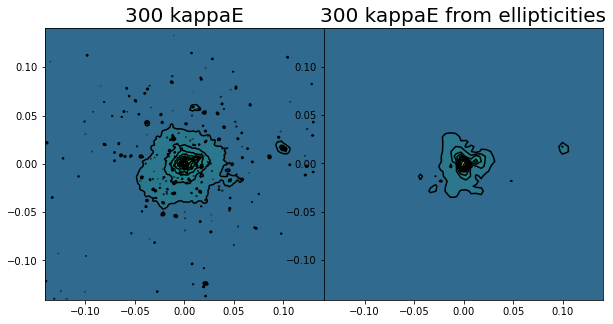

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))
plt.subplots_adjust(wspace=0, hspace=0)
levels=np.linspace(-1,2,20)

#plot 300 convergence map
X_300, Y_300 = np.meshgrid(ra, dec)
ax[0].set_title('300 kappaE', fontsize = 20)
ax[0].contourf(X_300, Y_300, kappa, origin='upper', levels=levels)
ax[0].contour(X_300, Y_300, kappa, origin='upper', levels=levels, colors = 'k')
ax[1].set_title('300 kappaE from ellipticities', fontsize = 20)
ax[1].contourf(-X, Y, -kappaE.T,  origin='upper', levels=levels)
ax[1].contour(-X, Y, -kappaE.T,  origin='upper', levels=levels, colors = 'k')